**Author(s):** Isidora Jankov, Andjelka Kovačević & Viktor Radović  
**Last updated:** 31.03.2021.

## Imports

In [74]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import seaborn as sns
import cmocean

# Local libraries
import functions as fun

# Global options
%matplotlib inline
sns.set_style('ticks')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Load locally stored LSST OpSim cadences

In [8]:
# Initialize a list for opsim cadence arrays (for g and r filters)
mjds_g = []
mjds_r = []

# Opsim cadence labels
labels = ['agnddf_v1.5_10yrs', 'alt_dust_v1.5_10yrs','baseline_samefilt_v1.5_10yrs','bulges_cadence_bs_v1.5_10yrs',
         'daily_ddf_v1.5_10yrs','dcr_nham2_ug_v1.5_10yrs','filterdist_indx5_v1.5_10yrs', 'footprint_gp_smoothv1.5_10yrs',
         'goodseeing_gri_v1.5_10yrs', 'greedy_footprint_v1.5_10yrs', 'roll_mod2_dust_sdf_0.20_v1.5_10yrs',
         'rolling_mod2_sdf_0.20_v1.5_10yrs', 'short_exp_2ns_5expt_v1.5_10yrs', 'spiders_v1.5_10yrs',
          'third_obs_pt45v1.5_10yrs','twilight_neo_mod2_v1.5_10yrs','u60_v1.5_10yrs', 'var_expt_v1.5_10yrs',
         'wfd_depth_scale0.90_v1.5_10yrs']

# Load OpSim cadences
for lb in labels:
    mjd_g = np.loadtxt('cadences/g/'+lb+'.dat')
    mjd_r = np.loadtxt('cadences/r/'+lb+'.dat')
    mjds_g.append(np.sort(mjd_g))
    mjds_r.append(np.sort(mjd_r))

## PART I: Calculations for g-filter

### 1.1 SF heatmaps with marginal histograms (*filt = g*)

In [10]:
def hist_SF_heatmap(mjd, label, lb='map', nlc=50, frame='observed', save=True, cmap='RdBu_r', c=30, err='squared', 
                    filt='?', ra='?', dec='?'):
    
    # Define redshift bins
    zbin = np.linspace(0.5,7.5,8)
    # Add z=0
    zbin = np.insert(zbin,0,0)
    
    # Converting MJD to survey days
    long=int(mjd.max()-mjd.min()+1)
    swop=[]
    wedgeop=[]
    scop=[]
    edgecop=[]
    
    # Setup for progress bar
    total = len(zbin)*(nlc);
    progress = 0;
    
    # Generate a number (nlc) of light curves for each redshift bin
    for z in zbin:
        for w in range(nlc):
            # Generating continuous light curve (cadence = 1 day)
            tt, yy = fun.LC_conti(long, z=z, frame=frame)
            # Calculating structure function for the current continuous light curve
            sn, edgesn = fun.sf(tt,yy,z=z)
            scop.append(sn)
            edgecop.append(edgesn)
            # Generating OpSim light curve evaluated on the current continuous light curve
            top,yop=fun.LC_opsim(mjd,tt,yy)
            # Calculating structure function for the current OpSim light curve
            srol,edgesrol=fun.sf(top,yop,z=z)
            swop.append(srol)
            wedgeop.append(edgesrol)
            # Update progress
            fun.progressBar(progress, total);
            progress = progress + 1;

    swop=np.asarray(swop)
    swop=swop.reshape(9,nlc,99)
    scop=np.asarray(scop)
    scop=scop.reshape(9,nlc,99)
    razrol=[]
    
    # SF metric calculation
    for z in range(9):
        for r in range(nlc):
            razrol.append((np.nan_to_num(np.sqrt(scop[z,r,:]))-np.nan_to_num(np.sqrt(swop[z,r,:]))))
    
    razrol9=np.asarray(razrol)
    razrol9=razrol9.reshape(9,nlc,99)
    # We take the mean light curve for each redshift bin.
    raz2=np.nanmean(razrol9[:,:,:],axis=1)    
    
    # Start plotting
    sns.set_style('ticks')
    fig = plt.figure(figsize=(8,5.7))
    gs = GridSpec(2, 3, width_ratios=[0.5, 2, 0.5], height_ratios=[1.6, 0.5])
    gs.update(wspace=0.00, hspace=0.00)
      
    # Plot z histogram
    ax1 = plt.subplot(gs[0])
    
    z_hist = []
    for i in range(0,9):
        if err == 'abs':
            z_hist.append(np.abs(raz2[i,:]).sum())
        elif err == 'squared':
            z_hist.append(np.square(raz2[i,:]).sum())
        elif err == 'stack':
            z_hist.append(raz2[i,:].sum())
    
    z_hist = np.asarray(z_hist)
    ax1.fill_betweenx(zbin, z_hist/z_hist.max(), step="mid", color='thistle', edgecolor='indigo', linewidth=1)
    ax1.set_ylabel('z', fontsize=15, labelpad=5)
    ax1.set_ylim(0,7)
    ax1.set_xlim(0,1.1)
    ax1.xaxis.set_visible(False)
    ax1.tick_params(labelsize=11.5)
    
    # Plot countour
    ax2 = plt.subplot(gs[1])
    X, Y = np.meshgrid(np.log10(edgesn[:-1])+((np.log10(edgesn[1])-np.log10(edgesn[0]))/2), zbin)
    sf_max = raz2.max()
    sf_min = raz2.min()
    if ((sf_max > abs(sf_min)) & (sf_max >= 0) & (sf_min < 0)):
        con = ax2.contourf(X, Y, raz2, c, cmap=cmap, vmax=sf_max, vmin=-sf_max)
    elif ((sf_max < abs(sf_min)) & (sf_max >= 0) & (sf_min < 0)):
        con = ax2.contourf(X, Y, raz2, c, cmap=cmap, vmax=abs(sf_min), vmin=sf_min)
    else:
        con = ax2.contourf(X, Y, raz2, c, cmap=cmap, vmax=sf_max, vmin=sf_min)
    
    ax2.set_xlim(0,4)
    ax2.set_ylim(0,7)
    ax2.yaxis.set_visible(False)
    ax2.xaxis.set_visible(False)
    ax2.set_title('OPSIM: %s' %(label)+', RA: %s' %(ra)+', DEC: %s' %(dec)+', FILT: %s' %(filt), fontsize=12)
    ax2.tick_params(labelsize=11.5)
    
    # Plot colorbar
    ax3 = plt.subplot(gs[2])
    ax3.set_visible(False)
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('left', size='20%', pad=0.05)
    cbar = fig.colorbar(con, cax=cax)
    cbar.ax.set_ylabel(r'Averaged SF (1 day cad.) - SF (OPSIM)', fontsize=12, labelpad=7)
    cbar.ax.tick_params(labelsize=11.5)
    
    # Plot log(delta_t) histogram
    ax4 = plt.subplot(gs[4])
    t_hist = []
    for i in range(0,99):
        if err == 'abs':
            t_hist.append(np.abs(raz2[:,i]).sum())
        elif err == 'squared':
            t_hist.append(np.square(raz2[:,i]).sum())
        elif err == 'stack':
            t_hist.append(raz2[:,i].sum())
    
    t_hist = np.asarray(t_hist)
    t_bins = np.linspace(0,4,99)
    ax4.fill_between(t_bins,t_hist/t_hist.max(), step="mid",color='thistle', edgecolor='indigo', linewidth=1)
    ax4.set_xlabel(r'$\mathrm{log_{10}}(\Delta \mathrm{t})$',fontsize=14, labelpad=5)
    ax4.set_xlim(0,4)
    ax4.set_ylim(0,1.1)
    ax4.yaxis.set_visible(False)
    ax4.tick_params(labelsize=11.5)

    ax5 = plt.subplot(gs[5])
    ax5.set_visible(False)
    
    if save==True:
        plt.savefig('map_hist/'+lb+'.png', dpi=250)
    
    return z_hist, t_hist, raz2

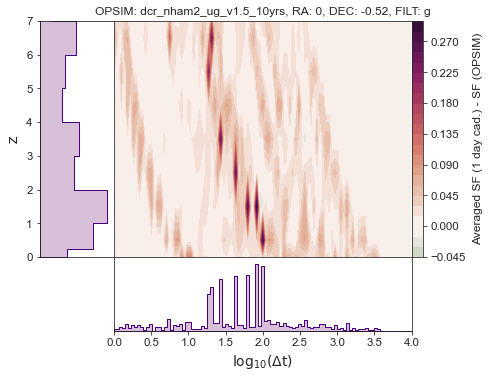

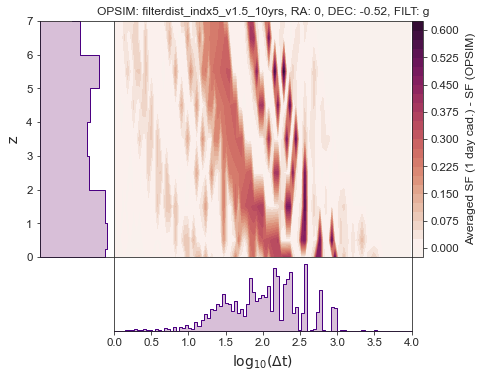

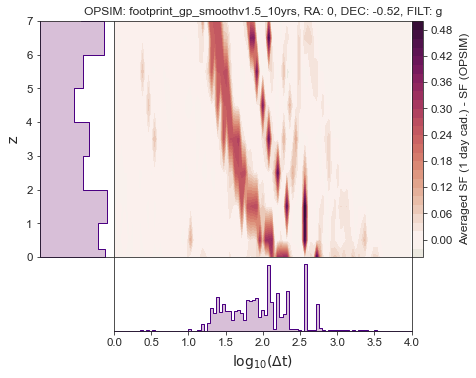

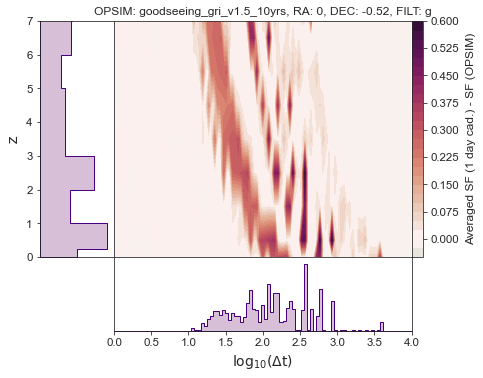

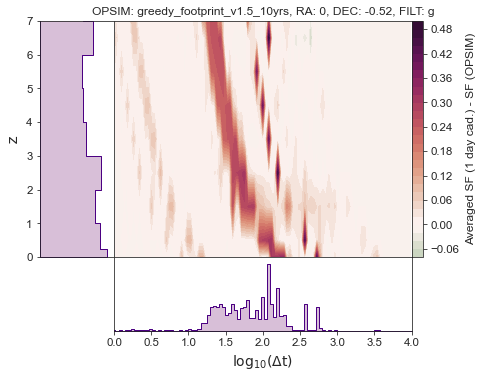

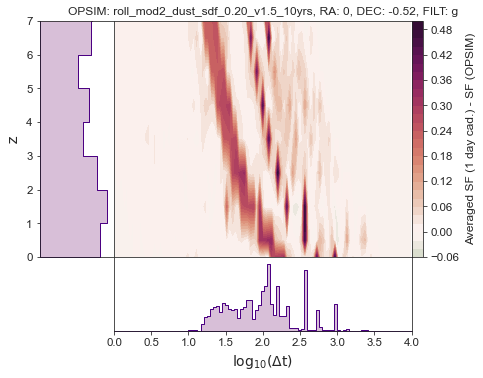

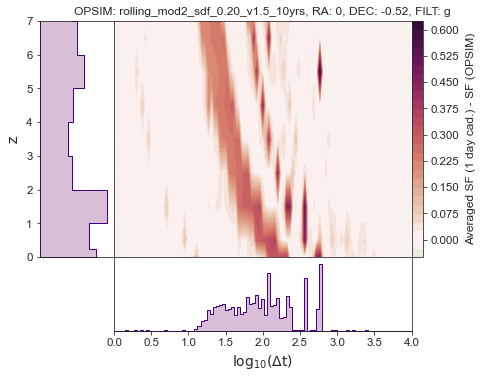

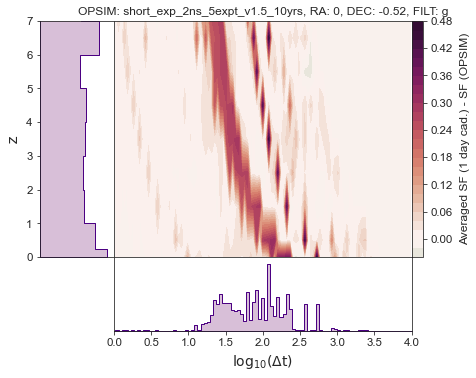

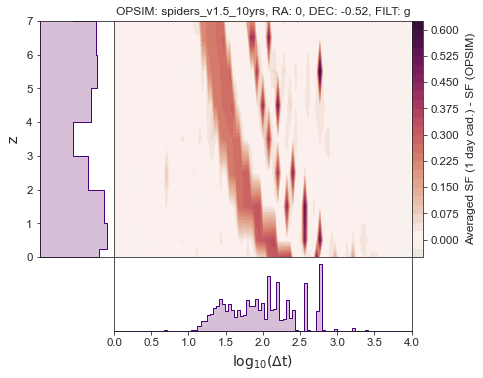

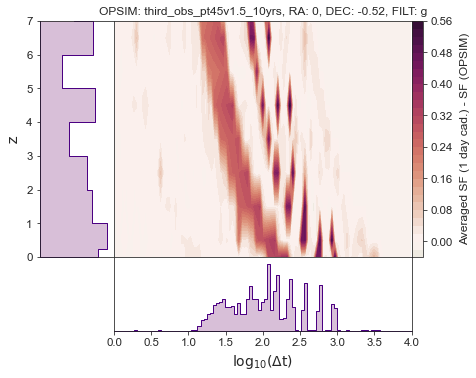

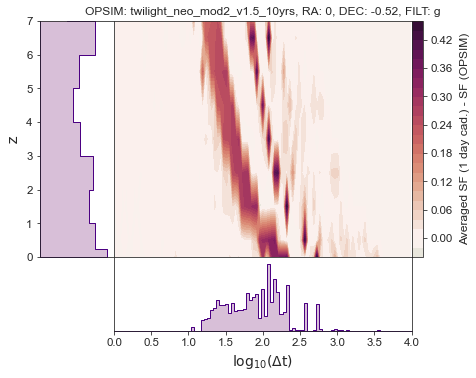

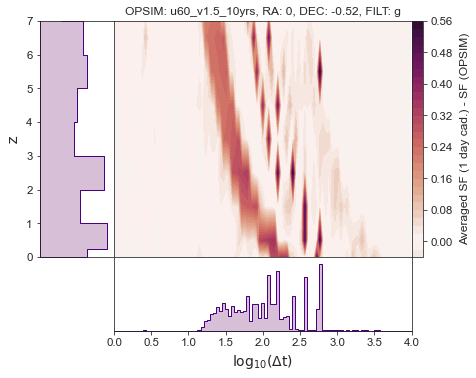

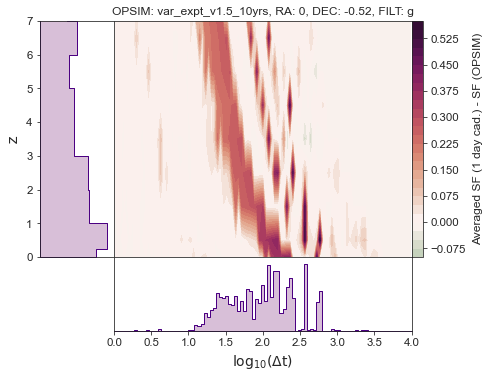

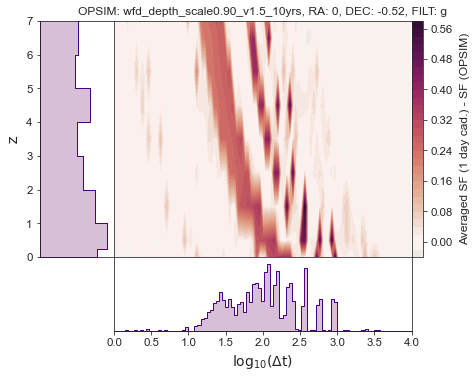

In [32]:
Z_fin_g = []
T_fin_g = []
R_fin_g = []
for m,l in zip(mjds_g, labels):
    z_hist, t_hist, raz2 = hist_SF_heatmap(m, l, lb=l+'_g', nlc=50, frame='observed', save=True, cmap=cmocean.cm.curl, c=30, 
                                           err='squared', filt='g', ra='0', dec='-0.52')
    Z_fin_g.append(z_hist)
    T_fin_g.append(t_hist)
    R_fin_g.append(raz2)

### 1.2 Plotting probability density functions (*filt = g*)

In [77]:
# Converting to pandas DataFrame
df_T_fin_g = pd.DataFrame(np.asarray(T_fin_g), index=labels)
df_Z_fin_g = pd.DataFrame(np.asarray(Z_fin_g), index=labels)
df_Z_fin_g.columns = ['z = 0', 'z = 0.5', 'z = 1.5', 'z = 2.5', 'z = 3.5', 'z = 4.5', 'z = 5.5', 'z = 6.5', 'z = 7.5']

# Sorting OpSims according to mean (for nice plots)
df_T_fin_g['mean'] = df_T_fin_g.T.describe().loc['mean']
df_T_fin_g = df_T_fin_g.sort_values(by = 'mean', ascending=False)

df_Z_fin_g['mean'] = df_Z_fin_g.T.describe().loc['mean']
df_Z_fin_g = df_Z_fin_g.sort_values(by = 'mean', ascending=False) 

In [78]:
df_T_fin_g

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,mean
baseline_samefilt_v1.5_10yrs,0.002846,0.000224,0.002926,0.004381,0.005518,0.007394,0.014687,0.015335,0.017289,0.010176,0.014990,0.009919,0.008961,0.011937,0.008113,0.007986,0.033573,0.037340,0.040144,0.025247,0.027176,0.034294,0.055259,0.063758,0.082787,0.072876,0.118937,0.130750,0.152078,0.184496,0.227253,0.212630,0.286358,0.248295,0.305210,0.408025,0.407017,0.333458,0.323408,0.387325,0.376317,0.363619,0.233156,0.355270,0.419508,0.580162,0.470226,0.344365,0.586594,0.450746,0.663165,0.549434,0.594481,0.843173,0.657588,0.520363,1.014690,0.528050,0.628463,0.406913,0.252378,0.008748,0.213176,1.142609,0.003404,0.311534,0.230029,0.231986,0.505486,0.581554,0.000947,0.005131,0.313950,0.262505,0.000662,0.004314,0.272052,0.004449,0.001527,0.254352,0.000199,0.000186,0.000614,0.001048,3.868707e-06,0.000403,1.950029e-03,0.000587,5.332016e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.197303
filterdist_indx5_v1.5_10yrs,0.000110,0.002481,0.000105,0.003196,0.007789,0.004278,0.007656,0.015052,0.010599,0.004902,0.018937,0.009783,0.012212,0.000422,0.018818,0.006878,0.002714,0.028436,0.022710,0.001786,0.037015,0.000500,0.039640,0.033674,0.062219,0.034542,0.021625,0.096556,0.053378,0.122018,0.184884,0.142415,0.242740,0.225702,0.290990,0.270378,0.400175,0.305299,0.292447,0.213747,0.327744,0.192036,0.239256,0.164738,0.298662,0.585374,0.425195,0.331846,0.356923,0.395184,0.368502,0.496215,0.212919,0.692854,0.605586,0.123518,0.517946,0.574171,0.642206,0.200454,0.259520,0.003386,0.200748,0.738012,0.002198,0.003315,0.018217,0.206135,0.445219,0.004728,0.002623,0.001230,0.263151,0.247446,0.001826,0.005937,0.010595,0.002351,0.000572,0.003161,0.000473,0.002611,0.012826,0.002390,1.110290e-03,0.002319,4.388628e-03,0.002308,4.205643e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135848
wfd_depth_scale0.90_v1.5_10yrs,0.000037,0.000110,0.000048,0.000434,0.004769,0.000428,0.000228,0.004931,0.000222,0.005806,0.000321,0.012433,0.000780,0.000595,0.000620,0.009104,0.000226,0.007827,0.000886,0.000590,0.000686,0.000504,0.000356,0.008574,0.035468,0.001855,0.000555,0.045915,0.052167,0.101238,0.109649,0.167629,0.180167,0.242242,0.260852,0.336331,0.273513,0.208538,0.279324,0.211189,0.142092,0.231477,0.250398,0.165673,0.343645,0.248859,0.409473,0.422284,0.374887,0.260467,0.516426,0.587588,0.213701,0.403688,0.520130,0.114909,0.142171,0.382921,0.418335,0.261681,0.016784,0.003328,0.220069,0.554307,0.002479,0.004032,0.007455,0.223462,0.282164,0.008024,0.001899,0.003994,0.278988,0.255177,0.000987,0.001308,0.004174,0.010500,0.001498,0.002230,0.001133,0.001290,0.005227,0.014188,1.663318e-04,0.001315,5.279344e-03,0.003359,2.066963e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110030
bulges_cadence_bs_v1.5_10yrs,0.002140,0.003030,0.002505,0.003966,0.009362,0.001069,0.008184,0.016747,0.009281,0.009727,0.001060,0.017079,0.000893,0.006706,0.006913,0.006222,0.011620,0.009943,0.017262,0.020774,0.023007,0.002913,0.001347,0.011360,0.025103,0.012631,0.057542,0.052597,0.088010,0.100179,0.138535,0.190734,0.163546,0.286727,0.241561,0.315210,0.301833,0.190792,0.265187,0.261454,0.145659,0.216744,0.230803,0.152581,0.301330,0.296094,0.393858,0.337715,0.325239,0.316000,0.277058,0.565388,0.214232,0.618270,0.284637,0.111626,0.418480,0.307405,0.151020,0.220100,0.001829,0.002963,0.200378,0.219532,0.006385,0.352339,0.001998,0.201532,0.017452,0.270546,0.000808,0.000892,0.012127,0.013831,0.001132,0.000488,0.260966,0.001722,0.000324,0.002350,0.000303,0.005454,0.001812,0.005745,6.514100e-09,0.000697,3.701324e-03,0.002082,1.251884e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105996
third_obs_pt45v1.5_10yrs,0.000199,0.000192,0.000086,0.000449,0.000594,0.000742,0.001448,0.008054,0.000433,0.000727,0.001604,0.000888,0.000502,

In [79]:
df_Z_fin_g

,z = 0,z = 0.5,z = 1.5,z = 2.5,z = 3.5,z = 4.5,z = 5.5,z = 6.5,z = 7.5,mean
baseline_samefilt_v1.5_10yrs,3.151102,2.806220,2.229605,1.868049,2.229728,2.378047,2.036247,1.222096,1.611877,2.170330
filterdist_indx5_v1.5_10yrs,1.840554,1.904456,1.832624,1.398186,1.325985,1.418923,1.667448,1.145007,0.915748,1.494326
wfd_depth_scale0.90_v1.5_10yrs,1.478375,1.737478,1.411565,1.113627,0.965509,1.284611,0.909053,0.990931,1.001827,1.210331
bulges_cadence_bs_v1.5_10yrs,1.603699,1.285039,1.246156,1.162442,0.930191,0.776709,1.141698,1.054849,1.292787,1.165952
third_obs_pt45v1.5_10yrs,1.438992,1.678666,1.289971,1.188246,0.728602,1.383929,0.556163,1.336718,0.859694,1.162331
goodseeing_gri_v1.5_10yrs,1.152794,2.066093,0.943519,1.653158,0.763230,0.786937,0.639613,0.960034,0.982608,1.105332
var_expt_v1.5_10yrs,1.290521,1.547519,1.133855,1.117913,0.780395,0.784114,0.678906,0.846629,0.625276,0.978347
spiders_v1.5_10yrs,1.058170,1.204624,1.148020,0.862454,0.594198,0.907149,1.031557,0.999243,0.595859,0.933475
daily_ddf_v1.5_10yrs,1.324009,1.031451,1.086655,0.841117,0.839783,0.494828,0.959938,0.627705,0.792493,0.888664
rolling_mod2_sdf_0.20_v1.5_10yrs,1.142505,0.998647,1.366823,0.657732,0.578616,0.685455,0.894125,0.757696,0.625796,0.856377


**PDF of metric values summed across redshift bins**

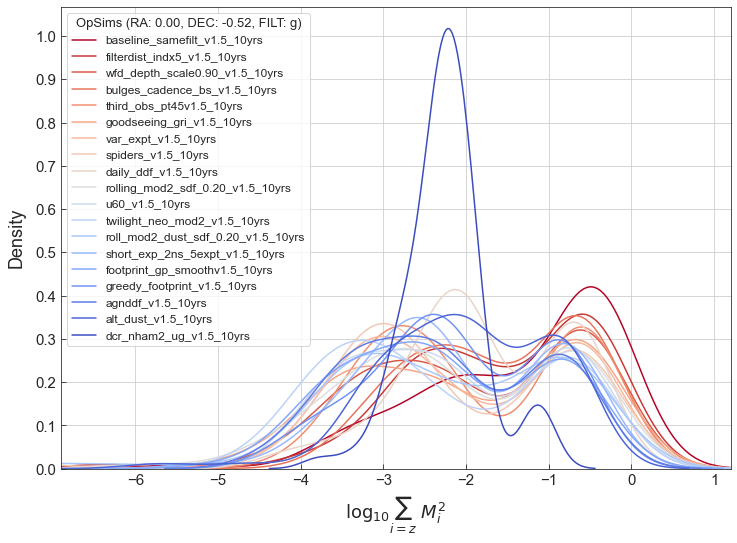

In [26]:
# g-filter
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\mathrm{log_{10}} \sum_{i=z} \ M^{2}_i$', fontsize=18, labelpad=7)
ax.set_ylabel('Density', fontsize=18, labelpad=10)
ax.set_xlim(-6.9, 1.2)
color=iter(plt.cm.coolwarm_r(np.linspace(0,1,19)))

lines_yzg = []
lines_xzg = []
idx_zg = []

df = df_T_fin_g[df_T_fin_g != 0.0].iloc[:,:-1]  # ignore zero values and last column (the mean)
for i in range(len(labels)):
    c=next(color)
    sns.kdeplot(np.log10(df.iloc[i]), linewidth=1.5, color=c, label=df.index[i], ax=ax)
    # Extract KDE plot info (for KL divergence calculation)
    kdeline = ax.lines[i]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    lines_xzg.append(xs)
    lines_yzg.append(ys)
    idx_zg.append(df.index[i])

ax.tick_params(axis='both', which='major', labelsize=15, direction='in', length = 5, pad = 5)
ax.legend(fontsize=12, title='OpSims (RA: 0.00, DEC: -0.52, FILT: g)', title_fontsize=13)
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
#plt.savefig('distributions/Dist_g_zstack_PDF.pdf', dpi=250)

**PDF of metric values summed across $\mathrm{log(\Delta t)}$ bins**

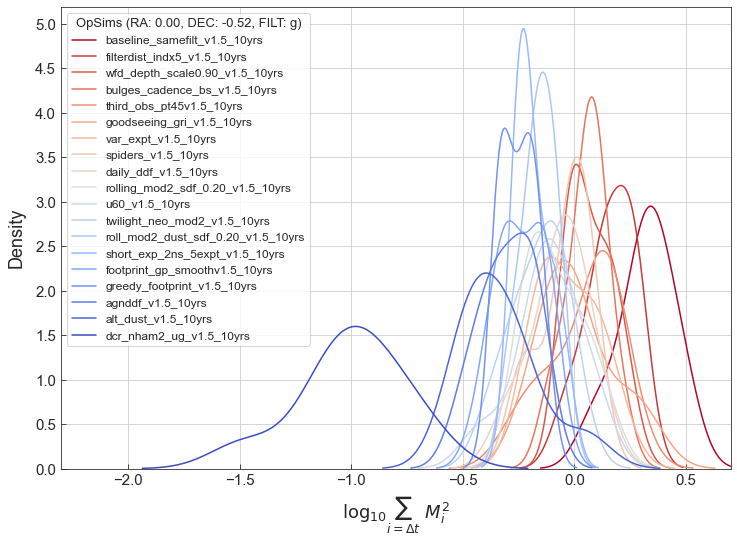

In [27]:
# g-filter
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\mathrm{log_{10}} \sum_{i = \Delta t} \ M^{2}_i$', fontsize=18, labelpad=7)
ax.set_ylabel('Density', fontsize=18, labelpad=10)
ax.set_xlim(-2.3,0.7)
#ax.set_title(r'Distribution of SF metric along redshift dimension (metric values along $\mathrm{log_{10}(\Delta t)}$ dimension are stacked)',
#            fontsize=14)
color=iter(plt.cm.coolwarm_r(np.linspace(0,1,19)))

lines_ytg = []
lines_xtg = []
idx_tg = []

df = df_Z_fin_g.iloc[:,:-1] # ignore last column(the mean)
for i in range(len(labels)):
    c=next(color)
    x = np.log10(df.iloc[i])
    sns.kdeplot(x, linewidth=1.5, color=c, label=df.index[i], ax=ax)
    # Extract KDE plot info (for KL divergence calculation)
    kdeline = ax.lines[i]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    lines_xtg.append(xs)
    lines_ytg.append(ys)
    idx_tg.append(df.index[i])

ax.tick_params(axis='both', which='major', labelsize=15, direction='in', length = 5, pad = 5)
ax.legend(fontsize=12, title='OpSims (RA: 0.00, DEC: -0.52, FILT: g)', title_fontsize=13, loc='upper left')
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
#plt.savefig('distributions/Dist_g_tstack_PDF.pdf', dpi=250)

**Distribution of metric values along $\mathrm{log(\Delta t)}$ dimension**

In [44]:
# log(delta_t) bin central values
tt, yy = fun.LC_conti(3650)
sn, edgesn = fun.sf(tt,yy)
X = np.log10(edgesn[:-1])+((np.log10(edgesn[1])-np.log10(edgesn[0]))/2)

# Redshift bin central values
Y = np.linspace(0.5,7.5,8)
Y = np.insert(Y,0,0)

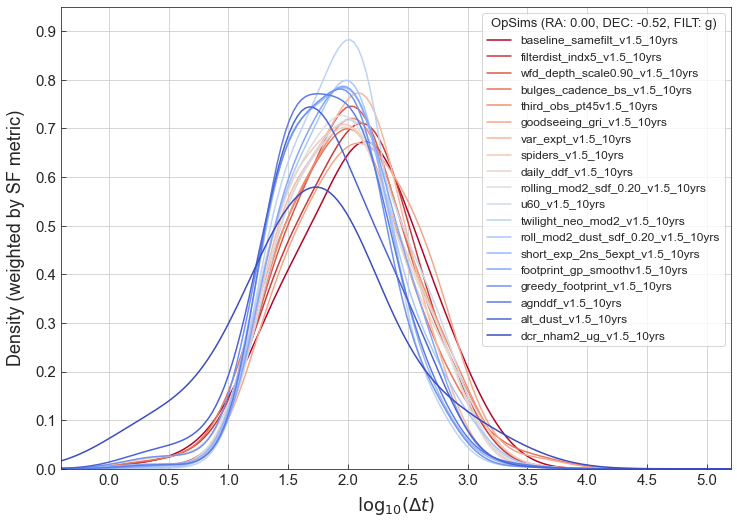

In [46]:
# g-filter
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\mathrm{log_{10}} (\Delta t)}$', fontsize=18, labelpad=7)
ax.set_ylabel('Density (weighted by SF metric)', fontsize=18, labelpad=10)
ax.set_xlim(-0.4,5.2)
ax.set_ylim(0,0.95)

color=iter(plt.cm.coolwarm_r(np.linspace(0,1,19)))

lines_ytg_vals = []
lines_xtg_vals = []
idx_tg_vals = []

df = df_T_fin_g.iloc[:,:-1]
for i in range(len(labels)):
    c=next(color)
    sns.kdeplot(X, weights=df.iloc[i], linewidth=1.5, color=c, label=df.index[i], ax=ax)
    # Extract KDE plot info (for KL divergence calculation)
    kdeline = ax.lines[i]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    lines_xtg_vals.append(xs)
    lines_ytg_vals.append(ys)
    idx_tg_vals.append(df.index[i])

ax.tick_params(axis='both', which='major', labelsize=15, direction='in', length = 5, pad = 5)
ax.legend(fontsize=12, title='OpSims (RA: 0.00, DEC: -0.52, FILT: g)', title_fontsize=13, loc='upper right')
ax.grid(True)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
#plt.savefig('distributions/Dist_g_dt.pdf', dpi=250)

**Distribution of metric values along redshift dimension**

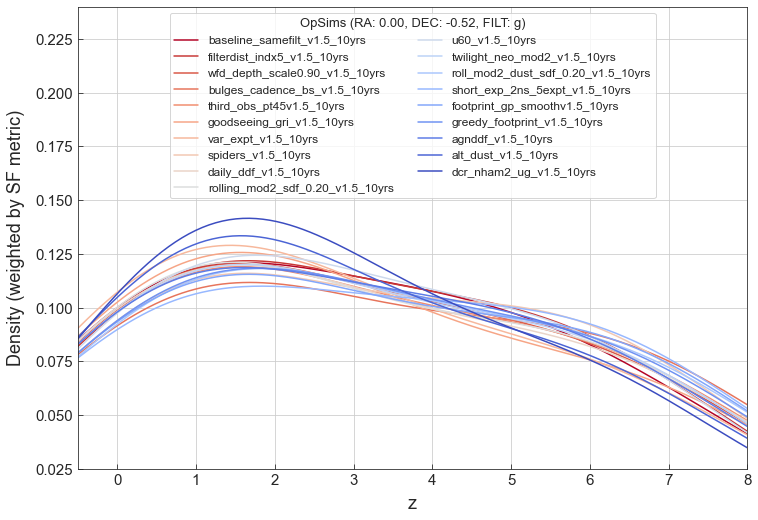

In [47]:
# g-filter
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111)
ax.set_xlabel('z', fontsize=18, labelpad=7)
ax.set_ylabel('Density (weighted by SF metric)', fontsize=18, labelpad=10)
ax.set_ylim(0.025,0.24)
ax.set_xlim(-0.5,8)
color=iter(plt.cm.coolwarm_r(np.linspace(0,1,19)))

lines_yzg_vals = []
lines_xzg_vals = []
idx_zg_vals = []

df = df_Z_fin_g.iloc[:,:-1]
for i in range(len(labels)):
    c=next(color)
    sns.kdeplot(Y, weights=df.iloc[i], linewidth=1.5, color=c, label=df.index[i], clip=(-0.5,8), ax=ax)
    # Extract KDE plot info (for KL divergence calculation)
    kdeline = ax.lines[i]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    lines_xzg_vals.append(xs)
    lines_yzg_vals.append(ys)
    idx_zg_vals.append(df.index[i])
    
ax.xaxis.set_major_locator(plt.MultipleLocator(1))   
ax.tick_params(axis='both', which='major', labelsize=15, direction='in', length = 5, pad = 5)
ax.legend(fontsize=12, title='OpSims (RA: 0.00, DEC: -0.52, FILT: g)', title_fontsize=13, loc='upper center', ncol =2)
ax.grid(True)
#plt.savefig('distributions/Dist_g_z.pdf', dpi=250)

In [76]:
# Sum over both dimensions (g-filter)
df_Z_fin_g.iloc[:,:-1].sum(axis=1).sort_values()

dcr_nham2_ug_v1.5_10yrs                1.007257
alt_dust_v1.5_10yrs                    4.567505
agnddf_v1.5_10yrs                      4.670562
greedy_footprint_v1.5_10yrs            5.102039
footprint_gp_smoothv1.5_10yrs          5.313421
short_exp_2ns_5expt_v1.5_10yrs         5.965794
roll_mod2_dust_sdf_0.20_v1.5_10yrs     6.304914
twilight_neo_mod2_v1.5_10yrs           6.422561
u60_v1.5_10yrs                         7.204930
rolling_mod2_sdf_0.20_v1.5_10yrs       7.707394
daily_ddf_v1.5_10yrs                   7.997980
spiders_v1.5_10yrs                     8.401275
var_expt_v1.5_10yrs                    8.805127
goodseeing_gri_v1.5_10yrs              9.947986
third_obs_pt45v1.5_10yrs              10.460980
bulges_cadence_bs_v1.5_10yrs          10.493569
wfd_depth_scale0.90_v1.5_10yrs        10.892977
filterdist_indx5_v1.5_10yrs           13.448931
baseline_samefilt_v1.5_10yrs          19.532972
dtype: float64

## PART II: Calculations for r-filter

### 2.1 SF heatmaps with marginal histograms (*filt = r*)

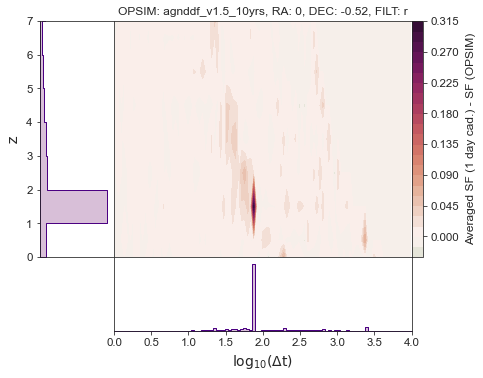

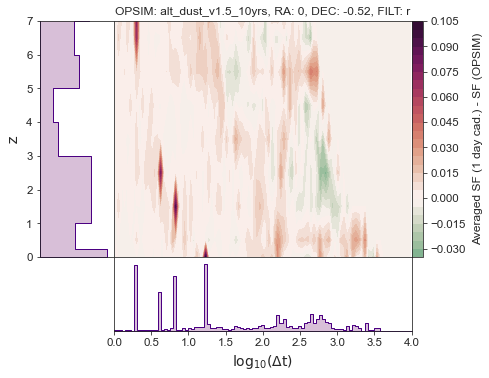

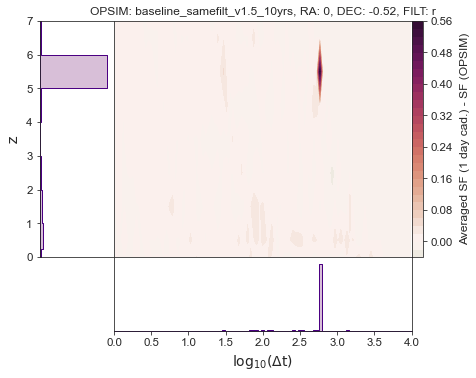

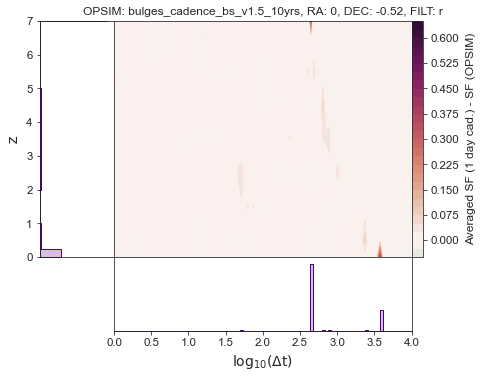

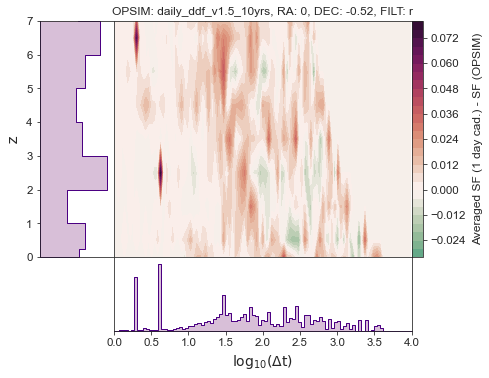

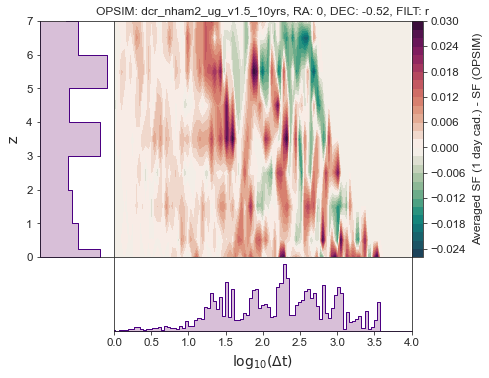

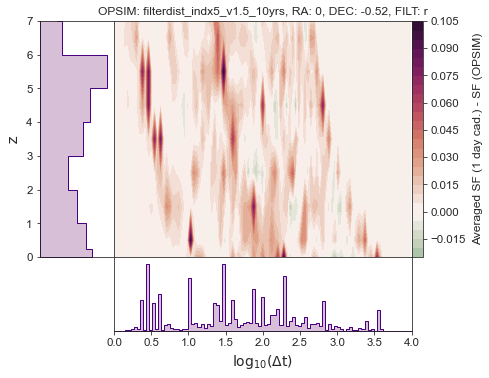

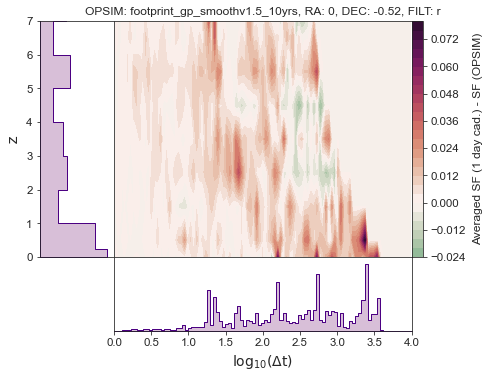

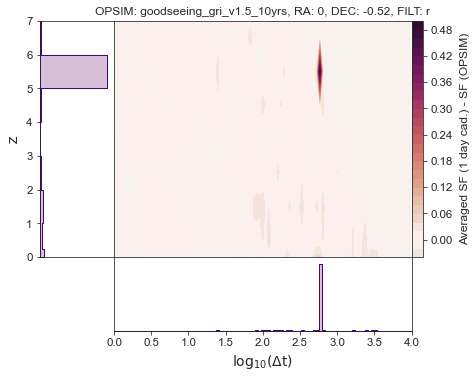

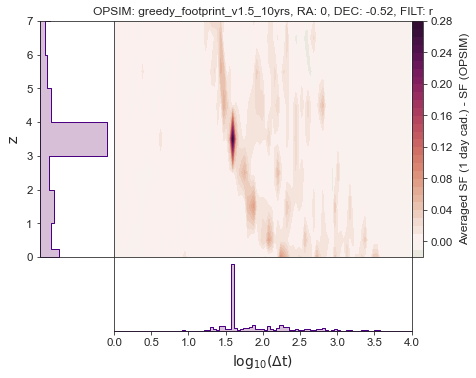

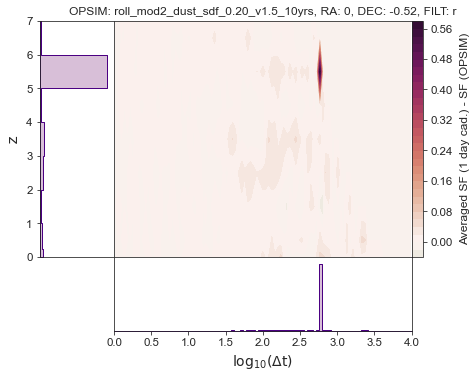

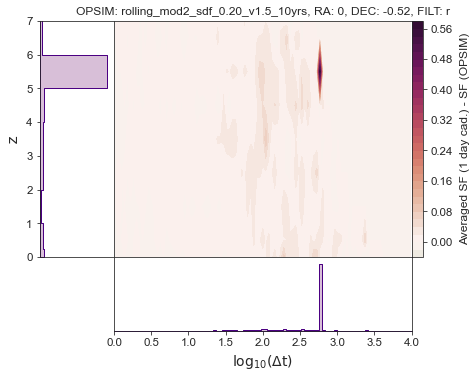

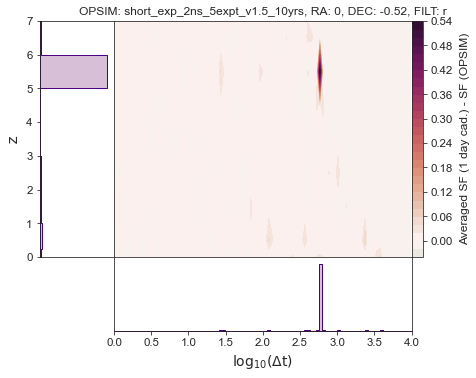

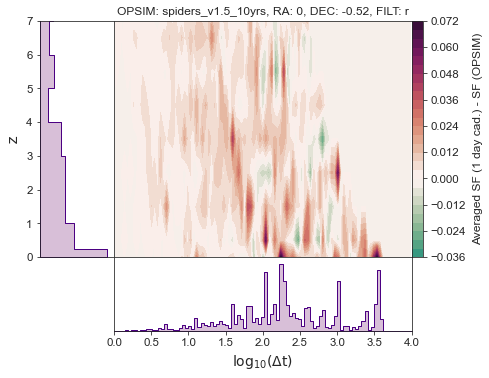

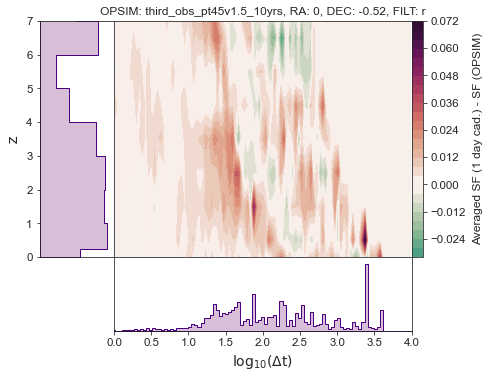

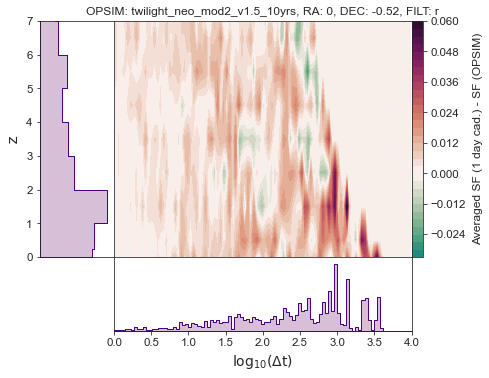

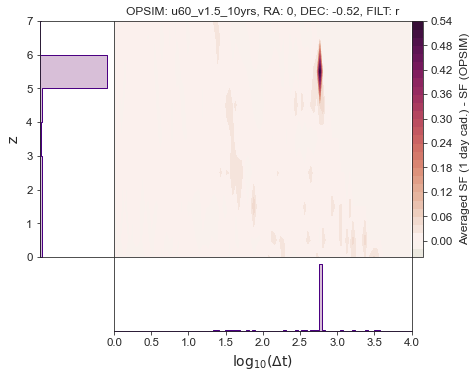

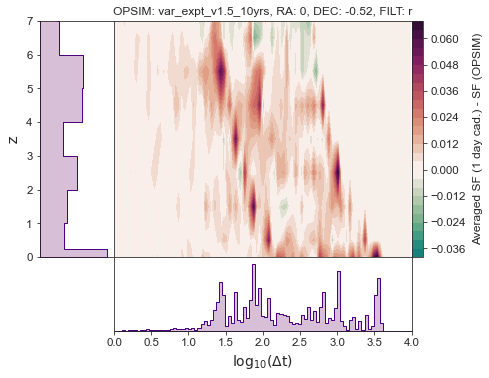

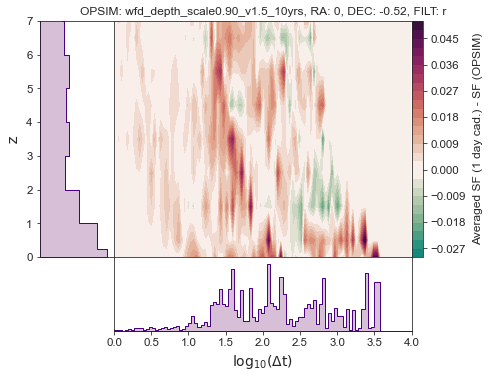

In [47]:
Z_fin_r = []
T_fin_r = []
R_fin_r = []
for m,l in zip(mjds_r, labels):
    z_hist, t_hist, raz2 = hist_SF_heatmap(m, l, lb=l+'_r', nlc=50, frame='observed', save=True, cmap=cmocean.cm.curl, c=30, 
                                           err='squared', filt='r', ra='0', dec='-0.52')
    Z_fin_r.append(z_hist)
    T_fin_r.append(t_hist)
    R_fin_r.append(raz2)

### 2.2 Plotting probability density functions (*filt = r*)

In [65]:
# Convering to pandas DataFrame
df_T_fin_r = pd.DataFrame(np.asarray(T_fin_r), index=labels)
df_Z_fin_r = pd.DataFrame(np.asarray(Z_fin_r), index=labels)
df_Z_fin_r.columns = ['z = 0', 'z = 0.5', 'z = 1.5', 'z = 2.5', 'z = 3.5', 'z = 4.5', 'z = 5.5', 'z = 6.5', 'z = 7.5']

# Sorting OpSims according to mean (for nice plots)
df_T_fin_r['mean'] = df_T_fin_r.T.describe().loc['mean']
df_T_fin_r = df_T_fin_r.sort_values(by = 'mean', ascending=False)

df_Z_fin_r['mean'] = df_Z_fin_r.T.describe().loc['mean']
df_Z_fin_r = df_Z_fin_r.sort_values(by = 'mean', ascending=False)

In [66]:
df_T_fin_r

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,mean
bulges_cadence_bs_v1.5_10yrs,0.000035,0.000051,0.000015,0.000086,0.000057,0.000016,0.000113,0.000265,0.000033,0.000072,0.000044,0.000100,0.000109,0.000071,0.000112,0.000249,0.000095,0.000113,0.000059,0.000165,0.000168,0.000064,0.000270,0.000150,0.000145,0.000149,0.000231,0.000386,0.000194,0.000266,0.001240,0.000333,0.000574,0.000797,0.000445,0.000482,0.000657,0.000874,0.001008,0.000359,0.000603,0.001228,0.002004,0.000233,0.001015,0.000881,0.001726,0.000834,0.000657,0.000646,0.000589,0.000566,0.000755,0.000773,0.000509,0.000890,0.000950,0.000730,0.001631,0.001123,0.000308,0.000667,0.000944,0.000389,0.000970,0.402954,0.001369,0.001746,0.000883,0.003823,0.001259,0.001863,0.000145,0.000540,0.001230,0.000020,0.000172,0.000267,0.000125,0.000144,0.000337,0.000164,0.000371,0.003681,0.000094,0.000063,0.000549,0.000748,1.245428e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005852
rolling_mod2_sdf_0.20_v1.5_10yrs,0.000013,0.000012,0.000037,0.000063,0.000010,0.000010,0.000031,0.000037,0.000017,0.000067,0.000041,0.000043,0.000086,0.000058,0.000037,0.000098,0.000135,0.000055,0.000044,0.000075,0.000120,0.000075,0.000085,0.000182,0.000073,0.000224,0.000130,0.000318,0.000408,0.000263,0.000651,0.000900,0.000589,0.001588,0.001412,0.001062,0.001850,0.001719,0.002270,0.002518,0.002453,0.000860,0.001349,0.003195,0.002052,0.002762,0.003591,0.003430,0.006156,0.006994,0.009557,0.006037,0.002721,0.005557,0.002407,0.002822,0.008018,0.005952,0.002830,0.003944,0.005310,0.002634,0.007052,0.001919,0.002717,0.002241,0.005563,0.005701,0.321585,0.002503,0.000279,0.000342,0.000656,0.002150,0.001012,0.000572,0.000113,0.000179,0.000172,0.000479,0.000201,0.000025,0.000283,0.003178,0.000271,0.000241,0.000126,0.000322,6.766225e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004727
roll_mod2_dust_sdf_0.20_v1.5_10yrs,0.000009,0.000006,0.000075,0.000004,0.000046,0.000028,0.000075,0.000048,0.000035,0.000178,0.000018,0.000044,0.000059,0.000029,0.000051,0.000078,0.000128,0.000040,0.000068,0.000094,0.000056,0.000094,0.000032,0.000186,0.000243,0.000133,0.000340,0.000152,0.000379,0.000190,0.000281,0.000288,0.000607,0.000650,0.000415,0.000488,0.000469,0.000337,0.001457,0.002151,0.001026,0.000885,0.001561,0.001363,0.002596,0.002195,0.001819,0.001476,0.001906,0.003333,0.001810,0.003573,0.005171,0.005444,0.004162,0.004939,0.002657,0.002847,0.002291,0.001899,0.003752,0.003262,0.002579,0.001030,0.002117,0.002755,0.001360,0.001563,0.331117,0.004514,0.003094,0.002446,0.000491,0.000589,0.001405,0.000050,0.000007,0.001344,0.001126,0.000921,0.000035,0.000508,0.002201,0.001875,0.000028,0.000060,0.000223,0.000288,1.173970e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004383
baseline_samefilt_v1.5_10yrs,0.000080,0.000133,0.000064,0.000118,0.000058,0.000357,0.000800,0.000509,0.000393,0.000114,0.000116,0.000761,0.000060,0.000394,0.000241,0.000410,0.000439,0.000203,0.000599,0.000870,0.000204,0.000155,0.000251,0.000105,0.000559,0.000944,0.000287,0.000560,0.000264,0.000580,0.000483,0.000341,0.000225,0.000816,0.000973,0.000962,0.002500,0.001067,0.000356,0.000715,0.000958,0.001261,0.001015,0.000494,0.001280,0.001666,0.002137,0.001540,0.000753,0.001625,0.000906,0.001463,0.001946,0.000434,0.001130,0.000622,0.000786,0.000665,0.001126,0.001424,0.001206,0.001470,0.001764,0.000857,0.000496,0.000666,0.002005,0.001391,0.303806,0.000621,0.000452,0.000776,0.001104,0.001302,0.000780,0.001325,0.000416,0.001503,0.001239,0.000445,0.000324,0.001267,0.000083,0.000515,0.000162,0.000890,0.000127,0.000100,2.151758e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003733
u60_v1.5_10yrs,0.000043,0.000007,0.000065,0.000026,0.000015,0.000053,0.000075,0.000205,0.000063,0.000078,0.000059,0.000062,0.000019,0.000033,0.000040,0.000242,0.0000

In [67]:
df_Z_fin_r

,z = 0,z = 0.5,z = 1.5,z = 2.5,z = 3.5,z = 4.5,z = 5.5,z = 6.5,z = 7.5,mean
bulges_cadence_bs_v1.5_10yrs,0.130551,0.006908,0.004754,0.008554,0.008694,0.006420,0.003472,0.003843,0.406168,0.064374
rolling_mod2_sdf_0.20_v1.5_10yrs,0.023305,0.015839,0.008497,0.014998,0.019796,0.020797,0.342136,0.011806,0.010814,0.051999
roll_mod2_dust_sdf_0.20_v1.5_10yrs,0.018281,0.010484,0.009160,0.017462,0.019986,0.004793,0.339379,0.007052,0.007272,0.048208
baseline_samefilt_v1.5_10yrs,0.008199,0.017893,0.009802,0.006171,0.003282,0.006268,0.309646,0.004541,0.003805,0.041067
u60_v1.5_10yrs,0.011660,0.012565,0.010614,0.009311,0.004225,0.012391,0.292911,0.003147,0.007977,0.040534
short_exp_2ns_5expt_v1.5_10yrs,0.008072,0.010696,0.004930,0.005102,0.002963,0.003917,0.291087,0.005937,0.005688,0.037599
goodseeing_gri_v1.5_10yrs,0.015505,0.007699,0.011117,0.004179,0.002361,0.005527,0.239320,0.003747,0.004939,0.032710
greedy_footprint_v1.5_10yrs,0.023230,0.014013,0.017951,0.011124,0.082468,0.013385,0.009363,0.006551,0.012147,0.021137
filterdist_indx5_v1.5_10yrs,0.025202,0.022150,0.018079,0.013534,0.020502,0.024201,0.032255,0.010551,0.008397,0.019430
agnddf_v1.5_10yrs,0.009929,0.010363,0.106382,0.010908,0.009975,0.006980,0.005053,0.003284,0.007814,0.018965


**PDF of metric values summed across redshift bins**

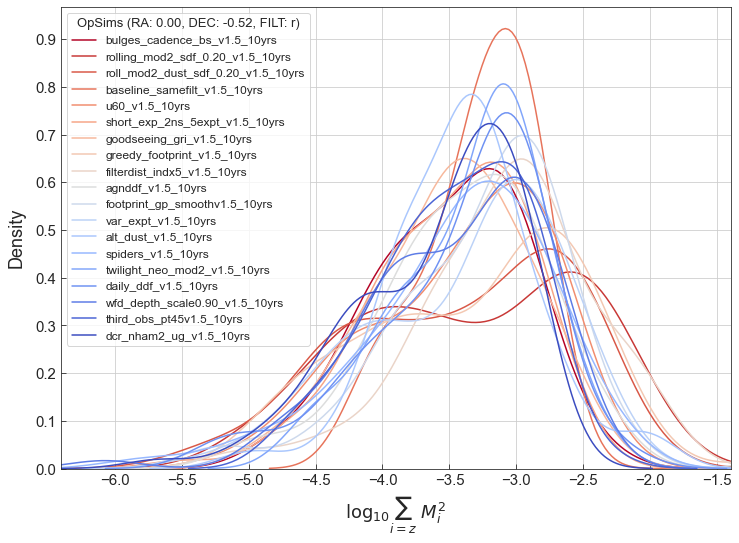

In [68]:
# r-filter
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\mathrm{log_{10}} \sum_{i=z} \ M^{2}_i$', fontsize=18, labelpad=7)
ax.set_ylabel('Density', fontsize=18, labelpad=10)
ax.set_xlim(-6.4, -1.4)
color=iter(plt.cm.coolwarm_r(np.linspace(0,1,19)))

#ax.set_title(r'Distribution of SF metric along $\mathrm{log_{10}(\Delta t)}$ dimension (metric values along redshift dimension are stacked)',
#            fontsize=14)

lines_yzr = []
lines_xzr = []
idx_zr = []

df = df_T_fin_r[df_T_fin_r != 0.0].iloc[:,:-1]
for i in range(len(labels)):
    c=next(color)
    sns.kdeplot(np.log10(df.iloc[i]), linewidth=1.5, color=c, label=df.index[i], ax=ax)
    # Extract KDE plot info (for KL divergence calculation)
    kdeline = ax.lines[i]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    lines_xzr.append(xs)
    lines_yzr.append(ys)
    idx_zr.append(df.index[i])

ax.tick_params(axis='both', which='major', labelsize=15, direction='in', length = 5, pad = 5)
ax.legend(fontsize=12, title='OpSims (RA: 0.00, DEC: -0.52, FILT: r)', title_fontsize=13, loc='upper left')
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
#plt.savefig('distributions/Dist_r_zstack_PDF.pdf',dpi=250)

**PDF of metric values summed across $\mathrm{log(\Delta t)}$ bins**

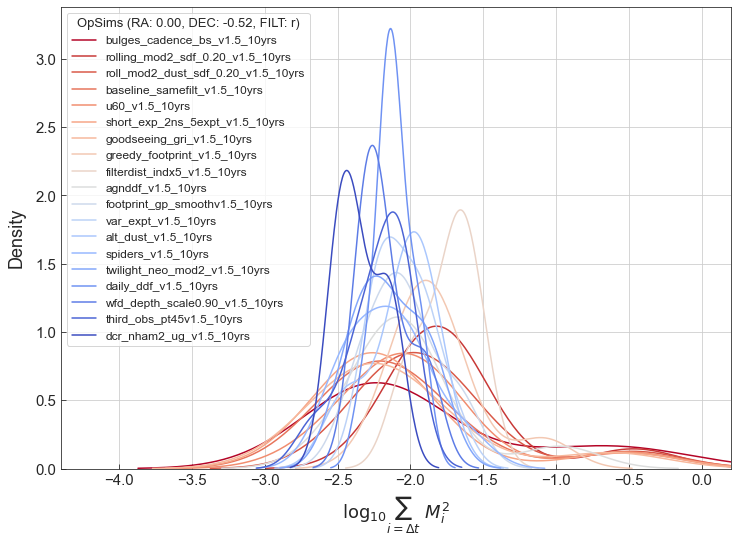

In [69]:
# r-filter
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\mathrm{log_{10}} \sum_{i = \Delta t} \ M^{2}_i$', fontsize=18, labelpad=7)
ax.set_ylabel('Density', fontsize=18, labelpad=10)
ax.set_xlim(-4.4,0.2)
#ax.set_title(r'Distribution of SF metric along redshift dimension (metric values along $\mathrm{log_{10}(\Delta t)}$ dimension are stacked)',
#            fontsize=14)
color=iter(plt.cm.coolwarm_r(np.linspace(0,1,19)))

lines_ytr = []
lines_xtr = []
idx_tr = []
df = df_Z_fin_r.iloc[:,:-1]
for i in range(len(labels)):
    c=next(color)
    sns.kdeplot(np.log10(df.iloc[i]), linewidth=1.5, color=c, label=df.index[i], ax=ax)
    # Extract KDE plot info (for KL divergence calculation)
    kdeline = ax.lines[i]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    lines_xtr.append(xs)
    lines_ytr.append(ys)
    idx_tr.append(df.index[i])

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.tick_params(axis='both', which='major', labelsize=15, direction='in', length = 5, pad = 5)
ax.legend(fontsize=12, title='OpSims (RA: 0.00, DEC: -0.52, FILT: r)', title_fontsize=13, loc='upper left')
ax.grid(True)
#plt.savefig('distributions/Dist_r_tstack_PDF.pdf',dpi=250)

**Distribution of metric values along $\mathrm{log(\Delta t)}$ dimension**

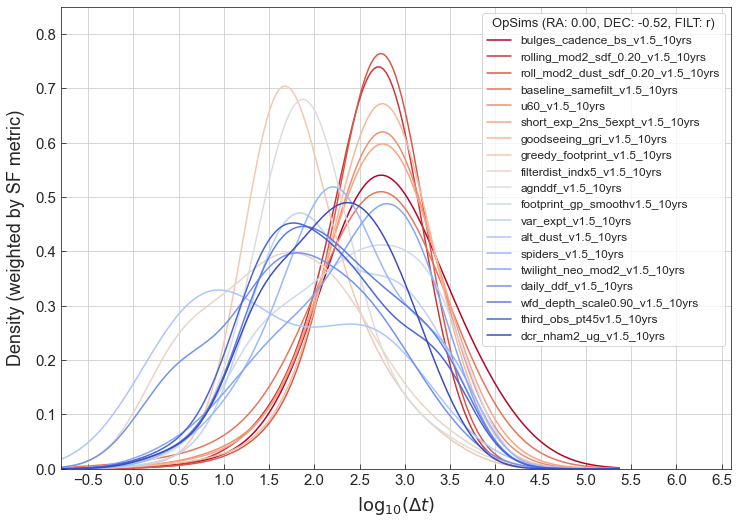

In [71]:
# r-filter
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\mathrm{log_{10}} (\Delta t)}$', fontsize=18, labelpad=7)
ax.set_ylabel('Density (weighted by SF metric)', fontsize=18, labelpad=10)
ax.set_xlim(-0.8,6.6)
ax.set_ylim(0,0.85)

color=iter(plt.cm.coolwarm_r(np.linspace(0,1,19)))

lines_ytr_vals = []
lines_xtr_vals = []
idx_tr_vals = []
df = df_T_fin_r.iloc[:,:-1]
for i in range(len(labels)):
    c=next(color)
    sns.kdeplot(X, weights=df.iloc[i], linewidth=1.5, color=c, label=df.index[i], ax=ax)
    # Extract KDE plot info (for KL divergence calculation)
    kdeline = ax.lines[i]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    lines_xtr_vals.append(xs)
    lines_ytr_vals.append(ys)
    idx_tr_vals.append(df.index[i])

ax.tick_params(axis='both', which='major', labelsize=15, direction='in', length = 5, pad = 5)
ax.legend(fontsize=12, title='OpSims (RA: 0.00, DEC: -0.52, FILT: r)', title_fontsize=13, loc='upper right')
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
#plt.savefig('distributions/Dist_r_dt.pdf', dpi=250)

**Distribution of metric values along redshift dimension**

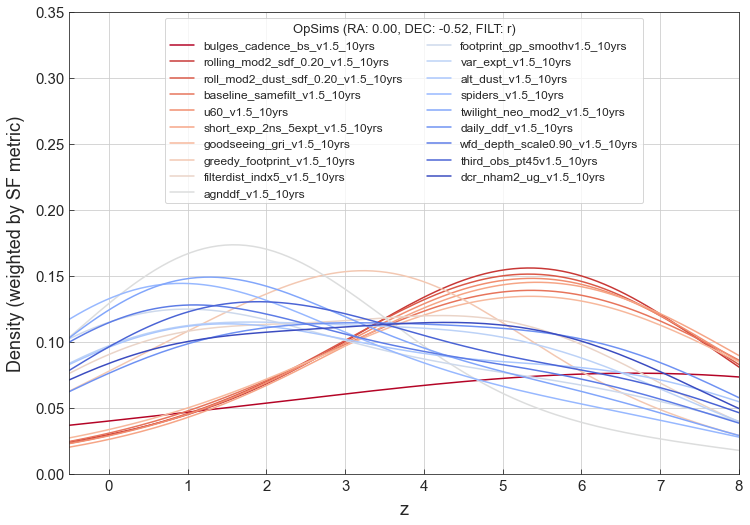

In [72]:
# r-filter
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111)
ax.set_xlabel('z', fontsize=18, labelpad=7)
ax.set_ylabel('Density (weighted by SF metric)', fontsize=18, labelpad=10)
ax.set_ylim(0,0.35)
ax.set_xlim(-0.5,8)
color=iter(plt.cm.coolwarm_r(np.linspace(0,1,19)))

lines_yzr_vals = []
lines_xzr_vals = []
idx_zr_vals = []

df = df_Z_fin_r.iloc[:,:-1]
for i in range(len(labels)):
    c=next(color)
    sns.kdeplot(Y, weights=df.iloc[i], linewidth=1.5, color=c, label=df.index[i], ax=ax)
    # Extract KDE plot info (for KL divergence calculation)
    kdeline = ax.lines[i]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    lines_xzr_vals.append(xs)
    lines_yzr_vals.append(ys)
    idx_zr_vals.append(df.index[i])
    
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.tick_params(axis='both', which='major', labelsize=15, direction='in', length = 5, pad = 5)
ax.legend(fontsize=12, title='OpSims (RA: 0.00, DEC: -0.52, FILT: r)', title_fontsize=13, ncol=2, loc='upper center')
ax.grid(True)
#plt.savefig('distributions/Dist_r_z.pdf', dpi=250)

In [75]:
# Sum over both dimensions (r-filter)
df_Z_fin_r.iloc[:,:-1].sum(axis=1).sort_values()

dcr_nham2_ug_v1.5_10yrs               0.043723
third_obs_pt45v1.5_10yrs              0.057753
wfd_depth_scale0.90_v1.5_10yrs        0.065465
daily_ddf_v1.5_10yrs                  0.071176
twilight_neo_mod2_v1.5_10yrs          0.072589
spiders_v1.5_10yrs                    0.077734
alt_dust_v1.5_10yrs                   0.084529
var_expt_v1.5_10yrs                   0.088364
footprint_gp_smoothv1.5_10yrs         0.093672
agnddf_v1.5_10yrs                     0.170688
filterdist_indx5_v1.5_10yrs           0.174870
greedy_footprint_v1.5_10yrs           0.190232
goodseeing_gri_v1.5_10yrs             0.294394
short_exp_2ns_5expt_v1.5_10yrs        0.338392
u60_v1.5_10yrs                        0.364802
baseline_samefilt_v1.5_10yrs          0.369604
roll_mod2_dust_sdf_0.20_v1.5_10yrs    0.433870
rolling_mod2_sdf_0.20_v1.5_10yrs      0.467987
bulges_cadence_bs_v1.5_10yrs          0.579364
dtype: float64